# Prediction Model

This notebook contains the code to create a ML model to predict the ratings (Metascore and User Score) a game can have considering its genre, platform and manufacturer

In [42]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Load and explore the dataset

In [43]:
import pandas as pd

# Load raw dataset
df_clean = pd.read_csv('metacritic_dataset_clean.csv')
# Convert 'release_date' to datetime
df_clean['release_date'] = pd.to_datetime(df_clean['release_date'], errors='coerce')
# Convert publishers to list
df_clean['publisher'] = df_clean['publisher'].apply(lambda x: eval(x) if pd.notnull(x) else [])
# Display dataset information
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22224 entries, 0 to 22223
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   name          22224 non-null  object        
 1   platform      22224 non-null  object        
 2   release_date  22224 non-null  datetime64[ns]
 3   metascore     22224 non-null  float64       
 4   user_score    22224 non-null  float64       
 5   developer     22224 non-null  object        
 6   publisher     22224 non-null  object        
 7   genre         22224 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 1.4+ MB


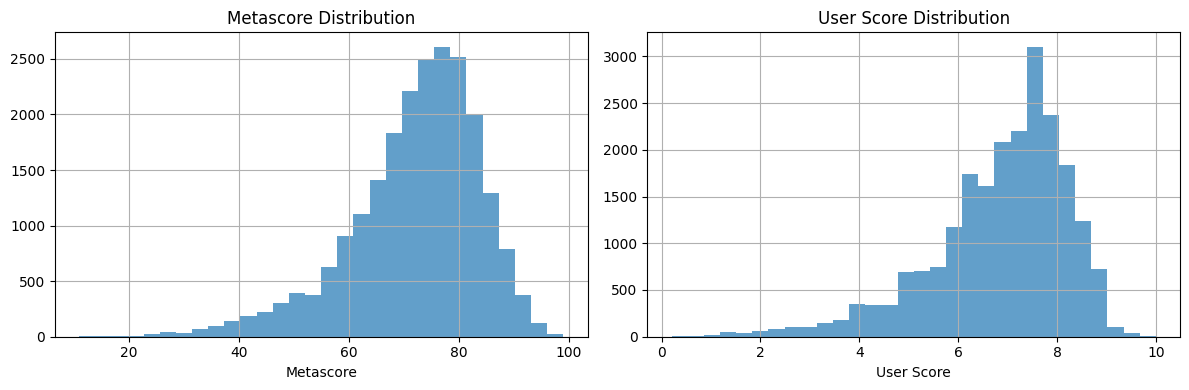


Correlation between Metascore and User Score: 0.519


In [44]:
# Distribution of target variables
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
df_clean['metascore'].hist(bins=30, ax=axes[0], alpha=0.7)
axes[0].set_title('Metascore Distribution')
axes[0].set_xlabel('Metascore')

df_clean['user_score'].hist(bins=30, ax=axes[1], alpha=0.7)
axes[1].set_title('User Score Distribution')
axes[1].set_xlabel('User Score')
plt.tight_layout()
plt.show()

# Correlation between metascore and user_score
correlation = df_clean['metascore'].corr(df_clean['user_score'])
print(f"\nCorrelation between Metascore and User Score: {correlation:.3f}")

In [45]:
def count_types(col):
    type_counts = df_clean[col].apply(lambda x: type(x).__name__).value_counts()
    print(f"Data type counts per column '{col}':")
    print(type_counts)

count_types('name')
count_types('platform')
count_types('release_date')
count_types('metascore')
count_types('user_score')
count_types('developer')
count_types('publisher')
count_types('genre')

Data type counts per column 'name':
name
str    22224
Name: count, dtype: int64
Data type counts per column 'platform':
platform
str    22224
Name: count, dtype: int64
Data type counts per column 'release_date':
release_date
Timestamp    22224
Name: count, dtype: int64
Data type counts per column 'metascore':
metascore
float    22224
Name: count, dtype: int64
Data type counts per column 'user_score':
user_score
float    22224
Name: count, dtype: int64
Data type counts per column 'developer':
developer
str    22224
Name: count, dtype: int64
Data type counts per column 'publisher':
publisher
list    22224
Name: count, dtype: int64
Data type counts per column 'genre':
genre
str    22224
Name: count, dtype: int64


## Generate new features

In [46]:
# Season
def get_season(date):
    if pd.isnull(date):
        return None
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df_clean['season'] = df_clean['release_date'].apply(get_season)
df_clean['season'].value_counts()

season
Fall      8098
Spring    5275
Summer    5056
Winter    3795
Name: count, dtype: int64

In [47]:
# Manufacturers
manufacturers_dict = {
    'Nintendo': ['Nintendo 64', 'GameCube', 'Wii', 'Wii U', 'Nintendo Switch', 'Nintendo Switch 2', 'Game Boy Advance', 'DS', '3DS'],
    'Sony': ['PlayStation', 'PlayStation 2', 'PlayStation 3', 'PlayStation 4', 'PlayStation 5', 'PSP', 'PlayStation Vita'],
    'Microsoft': ['Xbox', 'Xbox 360', 'Xbox One', 'Xbox Series X'],
    'Sega': ['Dreamcast'],
    'Apple': ['iOS (iPhone/iPad)'],
    'VR': ['Meta Quest'],
    'PC': ['PC']
}

In [48]:
# Create manufacturer column
def map_manufacturers(platform, manufacturers_dict=manufacturers_dict):
    for manufacturer, platforms in manufacturers_dict.items():
        if platform in platforms:
            return manufacturer
    return 'Other'

df_clean['manufacturer'] = df_clean['platform'].apply(lambda x: map_manufacturers(x))
df_clean.head()

,name,platform,release_date,metascore,user_score,developer,publisher,genre,season,manufacturer
0,The Legend of Zelda: Ocarina of Time,Nintendo 64,1998-11-23,99.0,9.1,Nintendo,"[Nintendo, Gradiente]",Open-World Action,Fall,Nintendo
1,SoulCalibur,Dreamcast,1999-09-08,98.0,7.6,Namco,[Namco],3D Fighting,Fall,Sega
2,SoulCalibur,iOS (iPhone/iPad),1999-09-08,73.0,7.8,Namco,[Namco],3D Fighting,Fall,Apple
3,SoulCalibur,Xbox 360,1999-09-08,79.0,7.3,Namco,[Namco],3D Fighting,Fall,Microsoft
4,Grand Theft Auto IV,PlayStation 3,2008-04-29,98.0,8.0,Rockstar North,"[Rockstar Games, Capcom]",Open-World Action,Spring,Sony


In [49]:
# Convert Metascore to 0 to 10 scale to match User Score
df_clean['metascore_scaled'] = df_clean['metascore'] / 10
df_clean.head()

,name,platform,release_date,metascore,user_score,developer,publisher,genre,season,manufacturer,metascore_scaled
0,The Legend of Zelda: Ocarina of Time,Nintendo 64,1998-11-23,99.0,9.1,Nintendo,"[Nintendo, Gradiente]",Open-World Action,Fall,Nintendo,9.9
1,SoulCalibur,Dreamcast,1999-09-08,98.0,7.6,Namco,[Namco],3D Fighting,Fall,Sega,9.8
2,SoulCalibur,iOS (iPhone/iPad),1999-09-08,73.0,7.8,Namco,[Namco],3D Fighting,Fall,Apple,7.3
3,SoulCalibur,Xbox 360,1999-09-08,79.0,7.3,Namco,[Namco],3D Fighting,Fall,Microsoft,7.9
4,Grand Theft Auto IV,PlayStation 3,2008-04-29,98.0,8.0,Rockstar North,"[Rockstar Games, Capcom]",Open-World Action,Spring,Sony,9.8


## Encode features

In [50]:
# Label encoding for season, platform, genre, manufacturer
df_clean['season_enc'] = df_clean['season'].astype('category').cat.codes
df_clean['platform_enc'] = df_clean['platform'].astype('category').cat.codes
df_clean['genre_enc'] = df_clean['genre'].astype('category').cat.codes
df_clean['manufacturer_enc'] = df_clean['manufacturer'].astype('category').cat.codes

df_clean.head()

,name,platform,release_date,metascore,user_score,developer,publisher,genre,season,manufacturer,metascore_scaled,season_enc,platform_enc,genre_enc,manufacturer_enc
0,The Legend of Zelda: Ocarina of Time,Nintendo 64,1998-11-23,99.0,9.1,Nintendo,"[Nintendo, Gradiente]",Open-World Action,Fall,Nintendo,9.9,0,6,67,2
1,SoulCalibur,Dreamcast,1999-09-08,98.0,7.6,Namco,[Namco],3D Fighting,Fall,Sega,9.8,0,2,4,4
2,SoulCalibur,iOS (iPhone/iPad),1999-09-08,73.0,7.8,Namco,[Namco],3D Fighting,Fall,Apple,7.3,0,23,4,0
3,SoulCalibur,Xbox 360,1999-09-08,79.0,7.3,Namco,[Namco],3D Fighting,Fall,Microsoft,7.9,0,20,4,1
4,Grand Theft Auto IV,PlayStation 3,2008-04-29,98.0,8.0,Rockstar North,"[Rockstar Games, Capcom]",Open-World Action,Spring,Sony,9.8,1,13,67,5


## Train model

In [51]:
# Split dataset into train and test
from sklearn.model_selection import train_test_split

X = df_clean[['season_enc', 'platform_enc', 'genre_enc', 'manufacturer_enc']]
y = df_clean['user_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape)
print(y_train.shape, y_test.shape)

(17779, 4) (4445, 4)
(17779,) (4445,)


In [52]:
# Train RandomForestRegressor model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Metrics
r2_orig = r2_score(y_test, y_pred)
mse_orig = mean_squared_error(y_test, y_pred)
mae_orig = mean_absolute_error(y_test, y_pred)

print(f"Random Forest Regressor:")
print(f"  R² Score: {r2_orig:.4f}")
print(f"  MSE: {mse_orig:.4f}")
print(f"  MAE: {mae_orig:.4f}")

Random Forest Regressor:
  R² Score: 0.0703
  MSE: 1.7997
  MAE: 1.0257


In [53]:
# Print predictions compared to actual values
predictions = model.predict(X_test)
comparison_df = pd.DataFrame(y_test).copy()
# comparison_df['predicted_metascore_scaled'] = predictions[:, 0]
comparison_df['predicted_user_score'] = predictions[:]
comparison_df.tail(10)

,user_score,predicted_user_score
15446,7.3,6.670940
21855,6.5,6.965772
7376,7.5,7.286110
10990,6.5,6.821492
3438,9.0,7.784323
8965,7.1,7.303984
9252,8.3,6.553087
7700,8.3,6.851311
9117,7.6,6.700361
1586,6.1,7.688666


The model's performance as it is is very bad, so we need to improve our features and change how we evaluate the model

## Improve performance of the model


TEMPORAL ANALYSIS:


C:\Users\Stadyn\AppData\Local\Temp\ipykernel_30628\3992656773.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_scores.index, y=monthly_scores.values, palette='coolwarm')


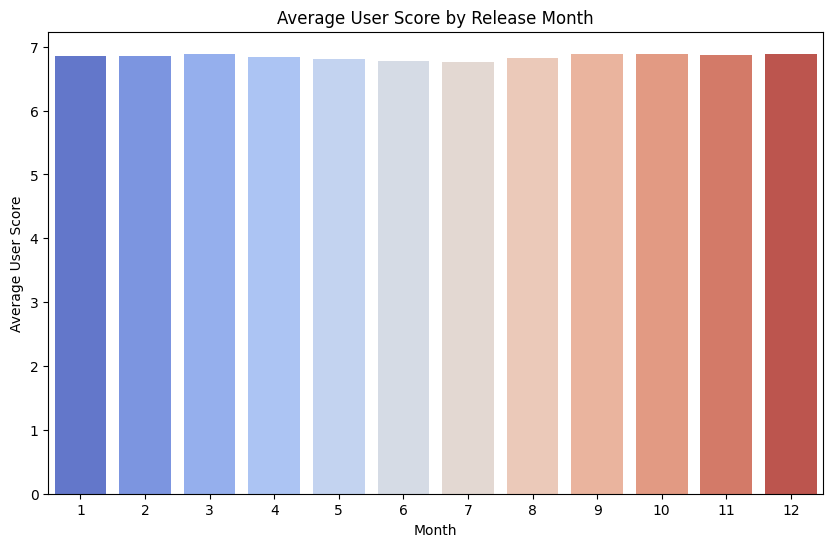

In [54]:
# Temporal Features
print("\nTEMPORAL ANALYSIS:")
df_clean['month'] = df_clean['release_date'].dt.month

# Month analysis  
monthly_scores = df_clean.groupby('month')['user_score'].mean().sort_values(ascending=False)
# Plot monthly average user scores
plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_scores.index, y=monthly_scores.values, palette='coolwarm')
plt.title('Average User Score by Release Month')
plt.xlabel('Month')
plt.ylabel('Average User Score')
plt.show()

In [55]:
# Platform-Genre interaction
print(f"\nPLATFORM-GENRE INTERACTIONS:")
platform_genre_scores = df_clean.groupby(['platform', 'genre'])['user_score'].agg(['mean', 'count']).reset_index()
platform_genre_scores = platform_genre_scores[platform_genre_scores['count'] >= 10]  # Min 10 games
print(f"Platform-Genre combinations with 10+ games: {len(platform_genre_scores)}")

# Show best platform-genre combinations
best_combinations = platform_genre_scores.nlargest(10, 'mean')
print(f"\nTop 10 Platform-Genre combinations:")
for _, row in best_combinations.iterrows():
    print(f"{row['platform']} - {row['genre']}: {row['mean']:.2f} (n={row['count']})")


PLATFORM-GENRE INTERACTIONS:
Platform-Genre combinations with 10+ games: 471

Top 10 Platform-Genre combinations:
PlayStation 2 - Turn-Based Tactics: 8.22 (n=13)
Game Boy Advance - Turn-Based Tactics: 8.22 (n=11)
DS - Trainer RPG: 8.14 (n=17)
GameCube - Open-World Action: 8.14 (n=10)
PlayStation - JRPG: 8.08 (n=19)
PlayStation 2 - Survival: 7.98 (n=40)
Wii U - Open-World Action: 7.85 (n=13)
PlayStation 5 - 3D Platformer: 7.84 (n=21)
Nintendo 64 - 3D Platformer: 7.84 (n=12)
PlayStation 2 - Linear Action Adventure: 7.78 (n=25)


In [56]:
# Create enhanced features
df_enhanced = df_clean.copy()

# Developer reputation (using cross-validation to avoid data leakage)
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

# Calculate developer average score using cross-validation to prevent leakage
kf = KFold(n_splits=5, shuffle=True, random_state=42)
df_enhanced['developer_avg_score'] = 0

for train_idx, val_idx in kf.split(df_enhanced):
    train_data = df_enhanced.iloc[train_idx]
    dev_means = train_data.groupby('developer')['user_score'].mean()
    global_mean = train_data['user_score'].mean()
    
    # Map developer averages, use global mean for unknown developers
    df_enhanced.loc[val_idx, 'developer_avg_score'] = df_enhanced.iloc[val_idx]['developer'].map(dev_means).fillna(global_mean)

# Temporal features
df_enhanced['year'] = df_enhanced['release_date'].dt.year
df_enhanced['month'] = df_enhanced['release_date'].dt.month
df_enhanced['is_holiday_release'] = df_enhanced['month'].isin([11, 12]).astype(int)  # Nov/Dec releases

# Platform-genre interaction
df_enhanced['platform_genre'] = df_enhanced['platform'] + "_" + df_enhanced['genre']

# Genre popularity (games per genre)
genre_counts = df_enhanced['genre'].value_counts()
df_enhanced['genre_popularity'] = df_enhanced['genre'].map(genre_counts)

# Platform age (years since first game on platform in dataset)
platform_first_year = df_enhanced.groupby('platform')['year'].min()
df_enhanced['platform_age'] = df_enhanced.apply(
    lambda row: row['year'] - platform_first_year[row['platform']], axis=1
)

print("Enhanced features created:")
print(f"Developer avg score range: {df_enhanced['developer_avg_score'].min():.2f} - {df_enhanced['developer_avg_score'].max():.2f}")
print(f"Platform-genre combinations: {df_enhanced['platform_genre'].nunique()}")
print(f"Holiday releases: {df_enhanced['is_holiday_release'].sum()}")
print(f"Platform age range: {df_enhanced['platform_age'].min()} - {df_enhanced['platform_age'].max()} years")

C:\Users\Stadyn\AppData\Local\Temp\ipykernel_30628\1208729443.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[7.47708333 7.60769231 7.875      ... 7.10487805 6.85580741 6.94358974]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_enhanced.loc[val_idx, 'developer_avg_score'] = df_enhanced.iloc[val_idx]['developer'].map(dev_means).fillna(global_mean)


Enhanced features created:
Developer avg score range: 0.40 - 9.90
Platform-genre combinations: 1690
Holiday releases: 3787
Platform age range: 0 - 30 years


In [57]:
# Prepare enhanced feature set
from sklearn.preprocessing import LabelEncoder

# Target encoding for high cardinality features (platform_genre)
# Using mean encoding with cross-validation to prevent overfitting
df_enhanced['platform_genre_encoded'] = 0

for train_idx, val_idx in kf.split(df_enhanced):
    train_data = df_enhanced.iloc[train_idx]
    pg_means = train_data.groupby('platform_genre')['user_score'].mean()
    global_mean = train_data['user_score'].mean()
    
    df_enhanced.loc[val_idx, 'platform_genre_encoded'] = df_enhanced.iloc[val_idx]['platform_genre'].map(pg_means).fillna(global_mean)

# Label encoding for remaining categorical features
le_genre = LabelEncoder()
le_platform = LabelEncoder()
le_manufacturer = LabelEncoder()

df_enhanced['genre_encoded'] = le_genre.fit_transform(df_enhanced['genre'])
df_enhanced['platform_encoded'] = le_platform.fit_transform(df_enhanced['platform'])
df_enhanced['manufacturer_encoded'] = le_manufacturer.fit_transform(df_enhanced['manufacturer'])

# Select features for the enhanced model
feature_columns = [
    'metascore_scaled',  # Strong predictor
    'developer_avg_score',  # Developer reputation
    'month',  # Seasonal effect
    'is_holiday_release',  # Holiday release timing
    'platform_age',  # Platform maturity
    'genre_popularity',  # Genre mainstream appeal
    'platform_genre_encoded',  # Platform-genre interaction
    'genre_encoded',  # Genre
    'platform_encoded',  # Platform
    'manufacturer_encoded'  # Manufacturer
]

X_enhanced = df_enhanced[feature_columns]
y_enhanced = df_enhanced['user_score']

print(f"Enhanced feature set shape: {X_enhanced.shape}")
print(f"Features: {feature_columns}")

Enhanced feature set shape: (22224, 10)
Features: ['metascore_scaled', 'developer_avg_score', 'month', 'is_holiday_release', 'platform_age', 'genre_popularity', 'platform_genre_encoded', 'genre_encoded', 'platform_encoded', 'manufacturer_encoded']


C:\Users\Stadyn\AppData\Local\Temp\ipykernel_30628\11599423.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[6.76       7.3        6.61976048 ... 6.925      6.512      7.09      ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_enhanced.loc[val_idx, 'platform_genre_encoded'] = df_enhanced.iloc[val_idx]['platform_genre'].map(pg_means).fillna(global_mean)


In [64]:
df_enhanced.to_csv('app/metacritic_dataset_features_enhanced.csv', index=False)
df_enhanced.head()

,name,platform,release_date,metascore,user_score,developer,publisher,genre,season,manufacturer,...,developer_avg_score,year,is_holiday_release,platform_genre,genre_popularity,platform_age,platform_genre_encoded,genre_encoded,platform_encoded,manufacturer_encoded
0,The Legend of Zelda: Ocarina of Time,Nintendo 64,1998-11-23,99.0,9.1,Nintendo,"[Nintendo, Gradiente]",Open-World Action,Fall,Nintendo,...,7.753279,1998,1,Nintendo 64_Open-World Action,823,2,8.750000,67,6,2
1,SoulCalibur,Dreamcast,1999-09-08,98.0,7.6,Namco,[Namco],3D Fighting,Fall,Sega,...,7.365385,1999,0,Dreamcast_3D Fighting,290,1,7.716667,4,2,4
2,SoulCalibur,iOS (iPhone/iPad),1999-09-08,73.0,7.8,Namco,[Namco],3D Fighting,Fall,Apple,...,7.388679,1999,0,iOS (iPhone/iPad)_3D Fighting,290,0,6.400000,4,23,0
3,SoulCalibur,Xbox 360,1999-09-08,79.0,7.3,Namco,[Namco],3D Fighting,Fall,Microsoft,...,7.477083,1999,0,Xbox 360_3D Fighting,290,1,6.760000,4,20,1
4,Grand Theft Auto IV,PlayStation 3,2008-04-29,98.0,8.0,Rockstar North,"[Rockstar Games, Capcom]",Open-World Action,Spring,Sony,...,7.664706,2008,0,PlayStation 3_Open-World Action,823,8,7.124528,67,13,5


## Enhanced Training

In [59]:
# Train enhanced models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Split the enhanced dataset
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42
)

print("Enhanced Model Performance Comparison:")
print("="*80)

enhanced_model = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_split=5, random_state=42)

# Train model
enhanced_model.fit(X_train_enh, y_train_enh)

# Predictions
y_pred = enhanced_model.predict(X_test_enh)

# Metrics
r2 = r2_score(y_test_enh, y_pred)
mse = mean_squared_error(y_test_enh, y_pred)
mae = mean_absolute_error(y_test_enh, y_pred)

# Cross-validation score
cv_scores = cross_val_score(model, X_train_enh, y_train_enh, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print(f"Enhanced Random Forest Regressor:")
print(f"  R² Score: {r2:.4f}")
print(f"  MSE: {mse:.4f}")
print(f"  MAE: {mae:.4f}")
print(f"  CV R² Mean: {cv_mean:.4f} (±{cv_std:.4f})")

Enhanced Model Performance Comparison:
Enhanced Random Forest Regressor:
  R² Score: 0.4251
  MSE: 1.1129
  MAE: 0.7818
  CV R² Mean: 0.4298 (±0.0065)


FEATURE IMPORTANCE (Enhanced Random Forest Regressor):
metascore_scaled         : 0.3641
developer_avg_score      : 0.1979
platform_genre_encoded   : 0.1222
platform_age             : 0.1018
genre_popularity         : 0.0609
genre_encoded            : 0.0589
month                    : 0.0450
platform_encoded         : 0.0330
manufacturer_encoded     : 0.0127
is_holiday_release       : 0.0035


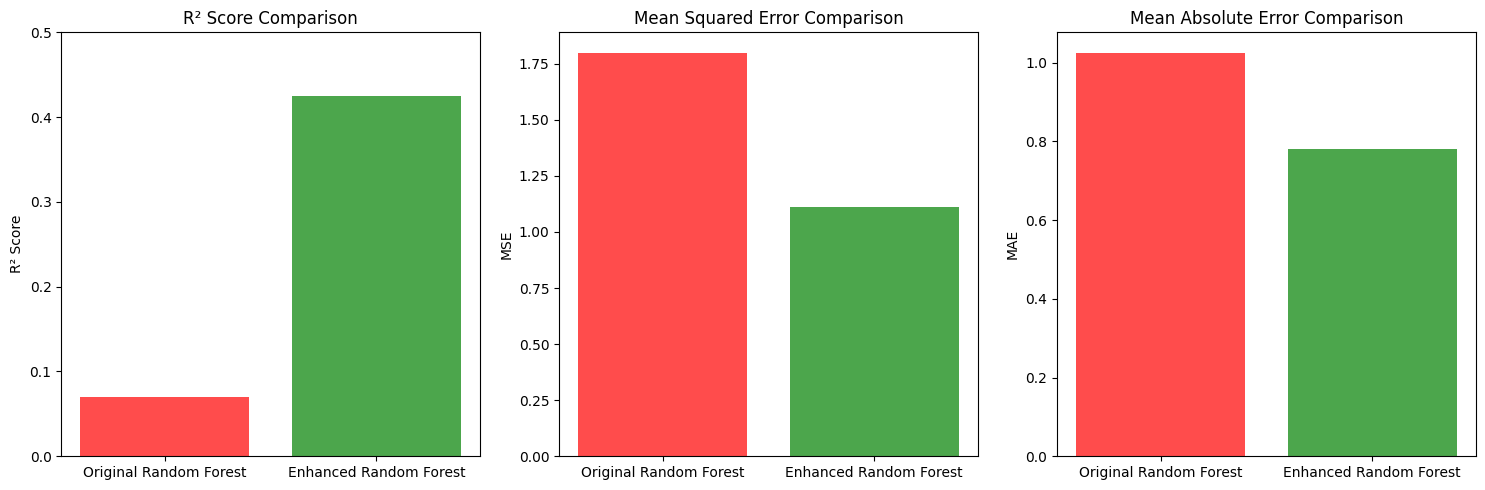

In [60]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': enhanced_model.feature_importances_
}).sort_values('importance', ascending=False)

print("FEATURE IMPORTANCE (Enhanced Random Forest Regressor):")
print("="*50)
for _, row in feature_importance.iterrows():
    print(f"{row['feature']:<25}: {row['importance']:.4f}")

# Visualization of improvement
import matplotlib.pyplot as plt

models_comparison = pd.DataFrame({
    'Model Type': ['Original Random Forest', 'Enhanced Random Forest'],
    'R² Score': [r2_orig, r2],
    'MSE': [mse_orig, mse],
    'MAE': [mae_orig, mae]
})

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# R² Score comparison
axes[0].bar(models_comparison['Model Type'], models_comparison['R² Score'], 
           color=['red', 'green'], alpha=0.7)
axes[0].set_title('R² Score Comparison')
axes[0].set_ylabel('R² Score')
axes[0].set_ylim(0, 0.5)

# MSE comparison
axes[1].bar(models_comparison['Model Type'], models_comparison['MSE'], 
           color=['red', 'green'], alpha=0.7)
axes[1].set_title('Mean Squared Error Comparison')
axes[1].set_ylabel('MSE')

# MAE comparison
axes[2].bar(models_comparison['Model Type'], models_comparison['MAE'], 
           color=['red', 'green'], alpha=0.7)
axes[2].set_title('Mean Absolute Error Comparison')
axes[2].set_ylabel('MAE')

plt.tight_layout()
plt.show()

# Improvement summary
r2_improvement = ((r2 - r2_orig) / r2_orig) * 100
mse_improvement = ((mse - mse_orig) / mse_orig) * 100
mae_improvement = ((mae - mae_orig) / mae_orig) * 100

In [65]:
# Save the model
import joblib
joblib.dump(enhanced_model, 'app/metacritic_model.pkl')

['app/metacritic_model.pkl']

# Make a Prediction

In [86]:
# Predict a new game example
new_game = {
    'metascore': 80,  # Example Metascore 
    'month': 7,  # November release
    'developer': "EA Sports",  # Example developer
    'platform': "PlayStation 5",  # Example platform
    'genre': "Football Sim",  # Example genre
    'manufacturer': "Sony",  # Example manufacturer
}

new_game_df = pd.DataFrame([new_game])
new_game_df

,metascore,month,developer,platform,genre,manufacturer
0,80,7,EA Sports,PlayStation 5,Football Sim,Sony


In [87]:
def predict_game_score(game_data: dict, model=enhanced_model, features_df=df_enhanced):
    developer = game_data.get("developer", None)
    platform = game_data.get("platform", None)
    month = game_data.get("month", None)
    genre = game_data.get("genre", None)
    manufacturer = game_data.get("manufacturer", None)
    game_data["metascore_scaled"] = game_data["metascore"] / 10
    game_data.pop("metascore", None)
    game_data["developer_avg_score"] = features_df[features_df["developer"] == developer]["developer_avg_score"].iloc[0]
    game_data["platform_age"] = features_df[features_df["platform"] == platform]["platform_age"].iloc[0]
    game_data["is_holiday_release"] = 1 if month in [11, 12] else 0
    genre_counts = features_df['genre'].value_counts()
    game_data["genre_popularity"] = genre_counts.get(genre, 0)
    game_data["platform_genre_encoded"] = features_df[features_df["platform_genre"] == f"{platform}_{genre}"]["platform_genre_encoded"].iloc[0]
    game_data["genre_encoded"] = features_df[features_df["genre"] == genre]["genre_encoded"].iloc[0]
    game_data["platform_encoded"] = features_df[features_df["platform"] == platform]["platform_encoded"].iloc[0]
    game_data["manufacturer_encoded"] = features_df[features_df["manufacturer"] == manufacturer]["manufacturer_encoded"].iloc[0]

    game_data_df = pd.DataFrame([game_data])[feature_columns]
    predicted_score = model.predict(game_data_df)[0]
    return predicted_score

In [88]:
predicted_user_score = predict_game_score(new_game)
print(f"\nPredicted User Score for the new game: {predicted_user_score:.2f}/10")


Predicted User Score for the new game: 5.19/10
